In [2]:
#This code is for the MXene project


import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time
import scipy.integrate as integrate
import scipy.special as special

In [3]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)

Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [4]:
#    
def big_for(filelist, start_time, finish_time, max_peaks = 7, wavelength_start = 405, wavelength_end = 1000, 
            peakfind_start = 401):
    
    wavelengthvals = filelist[filelist.keys()[0]].attrs['wavelengths']
    data_start = (np.abs(wavelengthvals - wavelength_start)).argmin()
    data_end = (np.abs(wavelengthvals - wavelength_end)).argmin()
    peak_data_start = (np.abs(wavelengthvals - peakfind_start)).argmin()
    data_range = data_end - data_start
    peak_index_store = []
    wavelength_store = []
    name_store = []
    intensity_store_norm = []
    intensity_store = []
    peak_wavelengths_store = []
    peak_intensities_store = []
    min_indexes = []
    min_index_store = []
    min_wavelengths_store = []
    min_intensities_store = []
    
    #Search for reference spectrum   
    try:
        for i in range(0, len(filelist)):
            try:
                ref = filelist[filelist.keys()[i]].attrs['reference']
                print "Reference spectrum taken from spectrum: " 
                print filelist.keys()[i]
                break
            except KeyError:
                ref = filelist[filelist.keys()[0]]
                pass
    except KeyError:
        print """Coudn't find a stored reference attribute, \n
        find the file containing a reference and paste this into the code"""
        ref = filelist[filelist.keys()[0]]
    
    back = filelist[filelist.keys()[0]].attrs['background']
    x = wavelengthvals

    slash_loc = Alex_data.slashfinder(fname)

    spectrum_indexes = []
    num_peaks_store = []
    intensity_initial_peak_store = []
    initial_peak_wl_store = []
    second_peak_wl_store = []

    peak_width_guess = 50
    exp_number_of_peaks = 2

    no_spectra=-1

    for data_set in filelist.values():

        current_timestamp =  datetime.datetime.strptime(
                data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")

        no_spectra += 1

        if current_timestamp >= start_time and current_timestamp <= finish_time:

            print "Current spectrum: " + data_set.name[25:]

            spectrum_indexes = np.append(spectrum_indexes, [no_spectra])

            y_raw = np.array(data_set.value)
            y = (y_raw-back)/(ref-back)

            y_red = y[data_start:data_end]
            x_red = x[data_start:data_end]

            #Use Savitsky-Golay noise filter to remove noise if chosen


            y_filtered = sig.savgol_filter(y_red,23,3)
            y_filtered_corr = y_filtered - min(y_filtered)
            y_norm = (y_filtered_corr/max(y_filtered_corr))
            y_red = y_filtered
    #         else:
    #             y_red = y[data_start:data_end] - min(y[data_start:data_end])
    #             y_norm = (y_red/max(y_red))
    #             pass

            #Set peakfinder to only search above set wavelength value with 
            #peak_data_start

            #Automatically search for the correct threshold leading the code to 
            #find the defined number of peaks
            thresh_guess = 0.5
            find_peaks = False
            while find_peaks == False and exp_number_of_peaks != 0:
                peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                if len(peak_indexes) >= exp_number_of_peaks:
                    find_peaks = True
                elif thresh_guess <=0.01:
                    while find_peaks == False:
                        peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                         thres = thresh_guess, 
                                                         min_dist = peak_width_guess*2)
                        min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                        if len(peak_indexes) >= exp_number_of_peaks:
                            find_peaks = True
                        elif thresh_guess > 1:
                            print "Didn't find threshold for spectrum" + str(no_spectra)
                            print "Need to change expected number or peaks"
                            thresh_guess = 0.5
                            break
                        else:
                            thresh_guess += 0.01
                    break
                else:
                    thresh_guess -= 0.01

            peak_indexes = peak_indexes + peak_data_start
            min_indexes = min_indexes + peak_data_start
            peak_indexes_orig = peak_indexes
            num_peaks = len(peak_indexes_orig)
            
            #Crop and add points to minima peaks
            if len(min_indexes) > max_peaks:
                while len(min_indexes) > max_peaks:
                    min_indexes = np.delete(min_indexes,[max_peaks])
            elif len(min_indexes) < max_peaks:
                while len(min_indexes) < max_peaks:
                    min_indexes = np.append(min_indexes,[0])
            else:
                pass
            
            #Crop and add 0 to peaks
            if len(peak_indexes) > max_peaks:
                while len(peak_indexes) > max_peaks:
                    peak_indexes = np.delete(peak_indexes,[max_peaks])
            elif len(peak_indexes) < max_peaks:
                while len(peak_indexes) < max_peaks:
                    peak_indexes = np.append(peak_indexes,[0])
            else:
                pass

            peak_wavelengths = []
            min_wavelengths = []
            peak_intensities = []
            min_intensities = []
            for i in range(0,max_peaks):
                if peak_indexes[i] != 0:
                    peak_wavelengths = np.append(peak_wavelengths, 
                                                 [x_red[peak_indexes[i]]])
                else:
                    peak_wavelengths = np.append(peak_wavelengths, [0])
                    
                if peak_indexes[i] != 0:
                    peak_intensities = np.append(peak_intensities, 
                                                 [y_norm[peak_indexes[i]]])
                else:
                    peak_intensities = np.append(peak_intensities, [0])
                    
                if min_indexes[i] != 0:
                    min_wavelengths = np.append(min_wavelengths, 
                                                 [x_red[min_indexes[i]]])
                else:
                    min_wavelengths = np.append(min_wavelengths, [0])
                    
                if min_indexes[i] != 0:
                    min_intensities = np.append(min_intensities, 
                                                 [y_norm[min_indexes[i]]])
                else:
                    min_intensities = np.append(min_intensities, [0])

    
                

            #Gaussian fitting    

    #         try:
    #             multi_gauss_fit_a = Alex_data.gaussian_fit_2(y_norm, x_red, 
    #                                                          peak_indexes_orig, 
    #                                                          peak_intensities)
    #         except UnboundLocalError:
    #             print "Gauss fit didnt work for spectrum" + str(no_spectra) 
    #             pass
    #         else:
    #             pass

            wavelength_store.append(x_red)
            name_store.append(data_set.name[25:])
            intensity_store.append(y_red)
            intensity_store_norm.append(y_norm)
            peak_index_store.append(peak_indexes)
            min_index_store.append(min_indexes)
            peak_wavelengths_store.append(peak_wavelengths)
            peak_intensities_store.append(peak_intensities)
            min_wavelengths_store.append(min_wavelengths)
            min_intensities_store.append(min_intensities)
            num_peaks_store = np.append(num_peaks_store, num_peaks)
            intensity_initial_peak_store = np.append(intensity_initial_peak_store, 
                                                     peak_intensities[0])
            initial_peak_wl_store = np.append(initial_peak_wl_store,peak_wavelengths[0])
            second_peak_wl_store = np.append(second_peak_wl_store, peak_wavelengths[1])

        else:
            pass
        
    wavelength_store = np.array(wavelength_store)        
    intensity_store = np.array(intensity_store)
    name_store = np.array(name_store)
    intensity_store_norm = np.array(intensity_store_norm)
    peak_index_store = np.array(peak_index_store)
    min_index_store = np.array(min_index_store)
    min_wavelengths_store = np.array(min_wavelengths_store)
    min_intensities_store = np.array(min_intensities_store)
    peak_wavelengths_store = np.array(peak_wavelengths_store)
    peak_intensities_store = np.array(peak_intensities_store)
    num_peaks_store = np.array(num_peaks_store)
    intensity_initial_peak_store = np.array(intensity_initial_peak_store)
    initial_peak_wl_store = np.array(initial_peak_wl_store)
    second_peak_wl_store = np.array(second_peak_wl_store)
    
    return wavelength_store, intensity_store, name_store, intensity_store_norm, peak_index_store, peak_wavelengths_store,peak_intensities_store, num_peaks_store, intensity_initial_peak_store,initial_peak_wl_store, second_peak_wl_store, min_index_store, min_wavelengths_store, min_intensities_store  


In [5]:
#Calculate useful values
def val_calc(num_peaks_store, second_peak_wl_store, initial_peak_wl_store, wavelength_store, 
             intensity_initial_peak_store, intensity_store_norm, intensity_store, av_init_peak_pos = 660):
    av_num_peaks = np.mean(num_peaks_store)
    av_second_peak_pos = np.mean(second_peak_wl_store)
    av_init_peak_pos_stddev = np.std(initial_peak_wl_store)
    av_second_peak_pos_stdev = np.std(second_peak_wl_store)
    av_init_peak_pos = 660

    init_peak = []
    second_peak = []
    for i in range(0, len(initial_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_init_peak_pos + av_init_peak_pos_stddev):
            init_peak = np.append(init_peak, initial_peak_wl_store[i])
        else:
            pass
    av_init_peak = np.mean(init_peak)
    for i in range(0, len(second_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_second_peak_pos + av_second_peak_pos_stdev):
            second_peak = np.append(second_peak, second_peak_wl_store[i])
        else:
            pass
    # if answers[6] == True:    
    #     ax1.plot([av_init_peak]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    #     ax1.plot([av_second_peak_pos]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    # else:
    #     pass

    av_init_peak_intensities = np.mean(intensity_initial_peak_store)
    average_all_intensities_norm = np.mean(intensity_store_norm, axis=0)
    average_all_intensities = np.mean(intensity_store, axis=0)
    av_stddev_norm = (np.std((intensity_store_norm), axis=0, dtype = np.float64))/np.sqrt(len(wavelength_store))
    av_stddev = np.std((intensity_store), axis=0, dtype = np.float64)/np.sqrt(len(wavelength_store))


    min_peak_pos_av = wavelength_store[0][np.argmin(average_all_intensities_norm)]

    return av_init_peak_intensities, average_all_intensities_norm, average_all_intensities, av_stddev_norm, av_stddev, min_peak_pos_av

In [6]:
cd C:/Users/alexc/OneDrive-University Of Cambridge/Documents/PhD Project/Projects

[Error 3] The system cannot find the path specified: u'Users/alexc/OneDrive-University Of Cambridge/Documents/PhD Project/Projects'
C:\Users\alexc\Documents\PhD Project\Python data analysis scripts\Dark field scattering


In [66]:
data_f.close()

In [67]:
data_f = df.current()
fname = data_f.filename

No current data file, attempting to create...
C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/2018-10-11_MXene_on_hBN.h5
opening file:  C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/2018-10-11_MXene_on_hBN.h5


In [68]:
filelist_DF = data_f['OceanOpticsSpectrometer']
camlist_DF = data_f['LumeneraCamera']

In [51]:
start_time_tot = datetime.datetime.strptime('2018-09-14T12:21:43.952000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_tot = datetime.datetime.strptime('2018-09-14T14:10:42.291000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [52]:
#Select range of data from MXene on Si
start_time_Si = datetime.datetime.strptime('2018-09-14T12:21:43.952000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_Si = datetime.datetime.strptime('2018-09-14T12:34:38.991000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [53]:
#Select range of data from MXene on Au
start_time_Au = datetime.datetime.strptime('2018-09-14T12:34:38.991000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_Au = datetime.datetime.strptime('2018-09-14T14:10:42.291000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [97]:
start_time_tot_Au_hBN = datetime.datetime.strptime('2018-10-11T16:19:35.360000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_tot_Au_hBN = datetime.datetime.strptime('2018-10-11T17:52:11.652000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [69]:
#Select range of data from MXene on Au/hBN 2018-10-11_MXene_on_hBN.h5
start_time_Au_hBN = datetime.datetime.strptime('2018-10-11T16:49:01.452000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_Au_hBN = datetime.datetime.strptime('2018-10-11T17:17:06.541000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [70]:
#Select range of data from MXene on Au/hBN 2018-10-11_MXene_on_hBN.h5
start_time_Au_hBN_2 = datetime.datetime.strptime('2018-10-11T16:23:20.372000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_Au_hBN_2 = datetime.datetime.strptime('2018-10-11T16:49:01.452000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [71]:
#Select range of data from MXene on Au 2018-10-11_MXene_on_hBN.h5
start_time_Au_2 = datetime.datetime.strptime('2018-10-11T17:17:06.541000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_Au_2 = datetime.datetime.strptime('2018-10-11T17:52:11.652000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [57]:
wavelength_store_Si, intensity_store_Si, name_store_Si, intensity_store_norm_Si, \
peak_index_store_Si, peak_wavelengths_store_Si, peak_intensities_store_Si, num_peaks_store_Si,\
intensity_initial_peak_store_Si, initial_peak_wl_store_Si,\
second_peak_wl_store_Si, min_indexes_store_Si, \
min_wavelengths_store_Si, min_intensities_store_Si = big_for(filelist = filelist_DF, start_time = start_time_Si, finish_time = finish_time_Si, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Aui_NPl_0
Current spectrum: Si_NPl_1
Current spectrum: Si_NPl_10
Current spectrum: Si_NPl_11
Current spectrum: Si_NPl_12
Current spectrum: Si_NPl_13
Current spectrum: Si_NPl_14
Current spectrum: Si_NPl_15
Current spectrum: Si_NPl_16
Current spectrum: Si_NPl_17
Current spectrum: Si_NPl_18
Current spectrum: Si_NPl_19
Current spectrum: Si_NPl_2
Current spectrum: Si_NPl_20
Current spectrum: Si_NPl_21
Current spectrum: Si_NPl_22
Current spectrum: Si_NPl_23
Current spectrum: Si_NPl_24
Current spectrum: Si_NPl_25
Current spectrum: Si_NPl_26
Current spectrum: Si_NPl_3
Current spectrum: Si_NPl_4
Current spectrum: Si_NPl_5
Current spectrum: Si_NPl_6
Current spectrum: Si_NPl_7
Current spectrum: Si_NPl_8
Current spectrum: Si_NPl_9


In [58]:
wavelength_store_Au, intensity_store_Au, name_store_Au, intensity_store_norm_Au, \
peak_index_store_Au, peak_wavelengths_store_Au, peak_intensities_store_Au, num_peaks_store_Au,\
intensity_initial_peak_store_Au, initial_peak_wl_store_Au,\
second_peak_wl_store_Au, min_indexes_store_Au, \
min_wavelengths_store_Au, min_intensities_store_Au = big_for(filelist = filelist_DF, start_time = start_time_Au, finish_time = finish_time_Au, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Aui_NPl_0
Current spectrum: Aui_NPl_0
Current spectrum: Aui_NPl_1
Current spectrum: Aui_NPl_10
Current spectrum: Aui_NPl_11
Current spectrum: Aui_NPl_12
Current spectrum: Aui_NPl_13
Current spectrum: Aui_NPl_14
Current spectrum: Aui_NPl_15
Current spectrum: Aui_NPl_16
Current spectrum: Aui_NPl_17
Current spectrum: Aui_NPl_18
Current spectrum: Aui_NPl_19
Current spectrum: Aui_NPl_2
Current spectrum: Aui_NPl_20
Current spectrum: Aui_NPl_21
Current spectrum: Aui_NPl_22
Current spectrum: Aui_NPl_23
Current spectrum: Aui_NPl_24
Current spectrum: Aui_NPl_25
Current spectrum: Aui_NPl_26
Current spectrum: Aui_NPl_3
Current spectrum: Aui_NPl_4
Current spectrum: Aui_NPl_5
Current spectrum: Aui_NPl_6
Current spectrum: Aui_NPl_7
Current spectrum: Aui_NPl_8
Current spectrum: Aui_NPl_9
Current spectrum: Auj_NPl_0
Current spectrum: Auj_NPl_1
Current spectrum: Auj_NPl_10
Current spectrum: Auj_NPl_11
Current spectrum: Auj_NPl_12
Current spectrum: Auj_NPl_13
Curr

In [72]:
#2018-10-11_MXene_on_hBN.h5
wavelength_store_Au_hBN, intensity_store_Au_hBN, name_store_Au_hBN, intensity_store_norm_Au_hBN, \
peak_index_store_Au_hBN, peak_wavelengths_store_Au_hBN, peak_intensities_store_Au_hBN, num_peaks_store_Au_hBN,\
intensity_initial_peak_store_Au_hBN, initial_peak_wl_store_Au_hBN,\
second_peak_wl_store_Au_hBN, min_indexes_store_Au_hBN, \
min_wavelengths_store_Au_hBN, min_intensities_store_Au_hBN = big_for(filelist = filelist_DF, start_time = start_time_Au_hBN, finish_time = finish_time_Au_hBN, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Centre_area_0
Current spectrum: NPl_edge_2_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: NPl_edge_2_1
Current spectrum: NPl_edge_2_10
Current spectrum: NPl_edge_2_100
Current spectrum: NPl_edge_2_101
Current spectrum: NPl_edge_2_102
Current spectrum: NPl_edge_2_103
Current spectrum: NPl_edge_2_104
Current spectrum: NPl_edge_2_105
Current spectrum: NPl_edge_2_106
Current spectrum: NPl_edge_2_107
Current spectrum: NPl_edge_2_108
Current spectrum: NPl_edge_2_109
Current spectrum: NPl_edge_2_11
Current spectrum: NPl_edge_2_110
Current spectrum: NPl_edge_2_111
Current spectrum: NPl_edge_2_112
Current spectrum: NPl_edge_2_113
Current spectrum: NPl_edge_2_114
Current spectrum: NPl_edge_2_115
Current spectrum: NPl_edge_2_116
Current spectrum: NPl_edge_2_117
Current spectrum: NPl_edge_2_118
Current spectrum: NPl_edge_2_119
Current spectrum: NPl_edge_2_12
Current spectrum: NPl_edge_2_120
Current spectrum: NPl_edge_2_121
Current spectrum: NPl_edge_2_122
Current spectrum: NPl_edge_2_123
Current spectrum: NPl_edge_2_13
Current spectrum: NPl_edge_2_14
Current spectrum:

In [24]:
#2018-10-11_MXene_on_hBN.h5
wavelength_store_Au_hBN_2, intensity_store_Au_hBN_2, name_store_Au_hBN_2, intensity_store_norm_Au_hBN_2, \
peak_index_store_Au_hBN_2, peak_wavelengths_store_Au_hBN_2, peak_intensities_store_Au_hBN_2, num_peaks_store_Au_hBN_2,\
intensity_initial_peak_store_Au_hBN_2, initial_peak_wl_store_Au_hBN_2,\
second_peak_wl_store_Au_hBN_2, min_indexes_store_Au_hBN_2, \
min_wavelengths_store_Au_hBN_2, min_intensities_store_Au_hBN_2 = big_for(filelist = filelist_DF, start_time = start_time_Au_hBN_2, finish_time = finish_time_Au_hBN_2, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Centre_area_0
Current spectrum: NPl_10


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: NPl_11
Current spectrum: NPl_12
Current spectrum: NPl_13
Current spectrum: NPl_14
Current spectrum: NPl_15
Current spectrum: NPl_16
Current spectrum: NPl_17
Current spectrum: NPl_18
Current spectrum: NPl_19
Current spectrum: NPl_20
Current spectrum: NPl_21
Current spectrum: NPl_22
Current spectrum: NPl_23
Current spectrum: NPl_24
Current spectrum: NPl_25
Current spectrum: NPl_26
Current spectrum: NPl_27
Current spectrum: NPl_28
Current spectrum: NPl_29
Current spectrum: NPl_30
Current spectrum: NPl_31
Current spectrum: NPl_32
Current spectrum: NPl_33
Current spectrum: NPl_34
Current spectrum: NPl_35
Current spectrum: NPl_36
Current spectrum: NPl_37
Current spectrum: NPl_38
Current spectrum: NPl_39
Current spectrum: NPl_40
Current spectrum: NPl_41
Current spectrum: NPl_42
Current spectrum: NPl_43
Current spectrum: NPl_44
Current spectrum: NPl_45
Current spectrum: NPl_46
Current spectrum: NPl_47
Current spectrum: NPl_48
Current spectrum: NPl_49
Current spectrum: NPl_5
C

In [12]:
#2018-10-11_MXene_on_hBN.h5
wavelength_store_Au_2, intensity_store_Au_2, name_store_Au_2, intensity_store_norm_Au_2, \
peak_index_store_Au_2, peak_wavelengths_store_Au_2, peak_intensities_store_Au_2, num_peaks_store_Au_2,\
intensity_initial_peak_store_Au_2, initial_peak_wl_store_Au_2,\
second_peak_wl_store_Au_2, min_indexes_store_Au_2, \
min_wavelengths_store_Au_2, min_intensities_store_Au_2 = big_for(filelist = filelist_DF, start_time = start_time_Au_2, finish_time = finish_time_Au_2, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Centre_area_0
Current spectrum: NPl_offedge_2_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: NPl_offedge_2_1
Current spectrum: NPl_offedge_2_10
Current spectrum: NPl_offedge_2_100
Current spectrum: NPl_offedge_2_101
Current spectrum: NPl_offedge_2_102
Current spectrum: NPl_offedge_2_103
Current spectrum: NPl_offedge_2_104
Current spectrum: NPl_offedge_2_105
Current spectrum: NPl_offedge_2_106
Current spectrum: NPl_offedge_2_107
Current spectrum: NPl_offedge_2_108
Current spectrum: NPl_offedge_2_109
Current spectrum: NPl_offedge_2_11
Current spectrum: NPl_offedge_2_110
Current spectrum: NPl_offedge_2_111
Current spectrum: NPl_offedge_2_112
Current spectrum: NPl_offedge_2_113
Current spectrum: NPl_offedge_2_114
Current spectrum: NPl_offedge_2_115
Current spectrum: NPl_offedge_2_116
Current spectrum: NPl_offedge_2_117
Current spectrum: NPl_offedge_2_118
Current spectrum: NPl_offedge_2_119
Current spectrum: NPl_offedge_2_12
Current spectrum: NPl_offedge_2_120
Current spectrum: NPl_offedge_2_121
Current spectrum: NPl_offedge_2_122
Current spectrum: NPl_offedge_2_1

In [60]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_Si, average_all_intensities_norm_Si, \
average_all_intensities_Si, av_stddev_norm_Si, av_stddev_Si, \
min_peak_pos_av_Si = val_calc(num_peaks_store = num_peaks_store_Si, 
                             second_peak_wl_store = second_peak_wl_store_Si, 
                             initial_peak_wl_store = initial_peak_wl_store_Si, 
                             intensity_initial_peak_store = intensity_initial_peak_store_Si,  
                             wavelength_store = wavelength_store_Si, 
                             intensity_store_norm = intensity_store_norm_Si,
                             intensity_store = intensity_store_Si, av_init_peak_pos = 660)

In [61]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_Au, average_all_intensities_norm_Au, \
average_all_intensities_Au, av_stddev_norm_Au, av_stddev_Au, \
min_peak_pos_av_Au = val_calc(num_peaks_store = num_peaks_store_Au, 
                             second_peak_wl_store = second_peak_wl_store_Au, 
                             initial_peak_wl_store = initial_peak_wl_store_Au, 
                             intensity_initial_peak_store = intensity_initial_peak_store_Au,  
                             wavelength_store = wavelength_store_Au, 
                             intensity_store_norm = intensity_store_norm_Au,
                             intensity_store = intensity_store_Au, av_init_peak_pos = 660)

In [73]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_Au_hBN, average_all_intensities_norm_Au_hBN, \
average_all_intensities_Au_hBN, av_stddev_norm_Au_hBN, av_stddev_Au_hBN, \
min_peak_pos_av_Au_hBN = val_calc(num_peaks_store = num_peaks_store_Au_hBN, 
                             second_peak_wl_store = second_peak_wl_store_Au_hBN, 
                             initial_peak_wl_store = initial_peak_wl_store_Au_hBN, 
                             intensity_initial_peak_store = intensity_initial_peak_store_Au_hBN,  
                             wavelength_store = wavelength_store_Au_hBN, 
                             intensity_store_norm = intensity_store_norm_Au_hBN,
                             intensity_store = intensity_store_Au_hBN, av_init_peak_pos = 660)

In [74]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_Au_hBN_2, average_all_intensities_norm_Au_hBN_2, \
average_all_intensities_Au_hBN_2, av_stddev_norm_Au_hBN_2, av_stddev_Au_hBN_2, \
min_peak_pos_av_Au_hBN_2 = val_calc(num_peaks_store = num_peaks_store_Au_hBN_2, 
                             second_peak_wl_store = second_peak_wl_store_Au_hBN_2, 
                             initial_peak_wl_store = initial_peak_wl_store_Au_hBN_2, 
                             intensity_initial_peak_store = intensity_initial_peak_store_Au_hBN_2,  
                             wavelength_store = wavelength_store_Au_hBN_2, 
                             intensity_store_norm = intensity_store_norm_Au_hBN_2,
                             intensity_store = intensity_store_Au_hBN_2, av_init_peak_pos = 660)

In [75]:
#Average and useful values for green terrace NPs
av_init_peak_intensities_Au_2, average_all_intensities_norm_Au_2, \
average_all_intensities_Au_2, av_stddev_norm_Au_2, av_stddev_Au_2, \
min_peak_pos_av_Au_2 = val_calc(num_peaks_store = num_peaks_store_Au_2, 
                             second_peak_wl_store = second_peak_wl_store_Au_2, 
                             initial_peak_wl_store = initial_peak_wl_store_Au_2, 
                             intensity_initial_peak_store = intensity_initial_peak_store_Au_2,  
                             wavelength_store = wavelength_store_Au_2, 
                             intensity_store_norm = intensity_store_norm_Au_2,
                             intensity_store = intensity_store_Au_2, av_init_peak_pos = 660)

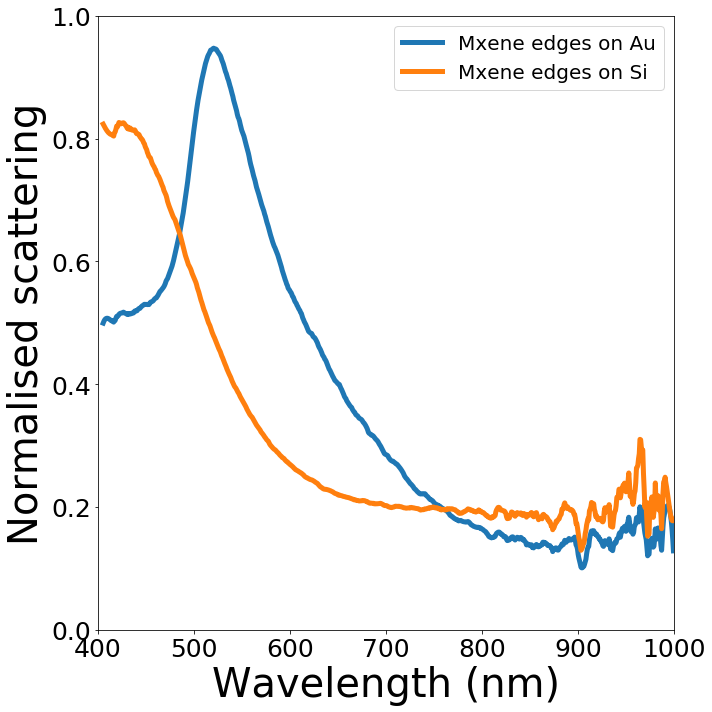

In [76]:
fig1 = plt.figure(1, figsize = (10, 10))
ax1 = fig1.add_subplot(111)
ax1.plot(wavelength_store_Au[0], average_all_intensities_norm_Au, label = 'Mxene edges on Au', linewidth = 5)
ax1.plot(wavelength_store_Si[0], average_all_intensities_norm_Si, label = 'Mxene edges on Si', linewidth = 5)
ax1.set_xlim(400, 1000)
ax1.set_ylim(0,1)
ax1.set_xlabel('Wavelength (nm)', fontsize = 40)
ax1.set_ylabel('Normalised scattering', fontsize = 40)
#ax1.title('Comparison of MXene edge scattering on and off Au')
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.legend( prop={'size': 20})

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/On_off_Au_comparison_norm.png', bbox_inches='tight')

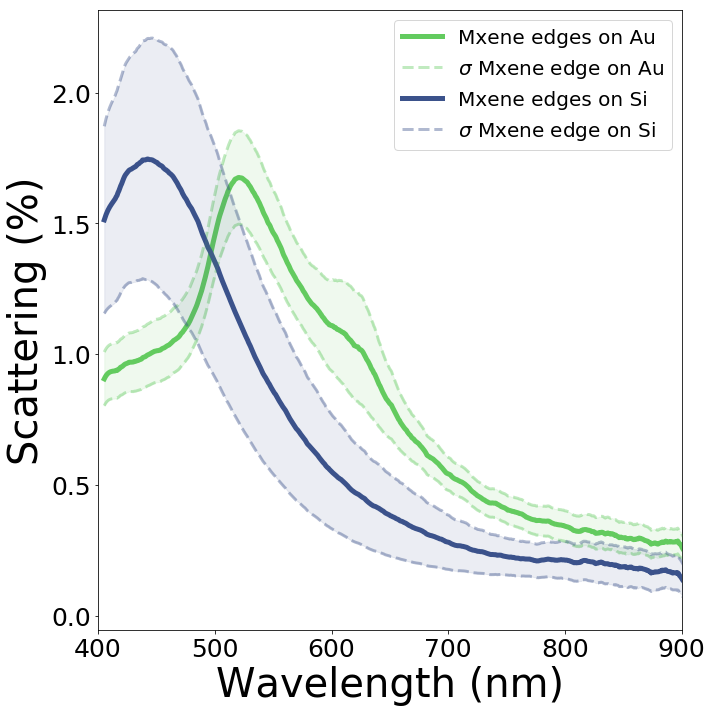

In [120]:
fig1 = plt.figure(1, figsize = (10, 10))
ax1 = fig1.add_subplot(111)
ax1.plot(wavelength_store_Au[0], average_all_intensities_Au*100, label = 'Mxene edges on Au', linewidth = 5, color = colours_exp[600])
ax1.plot(wavelength_store_Au[0], av_stddev_Au*100 + average_all_intensities_Au*100, '--',color = colours_exp[600], label = "$\sigma$ Mxene edge on Au",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Au[0], average_all_intensities_Au*100-av_stddev_Au*100, '--',color = colours_exp[600],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Au[0], average_all_intensities_Au*100 - av_stddev_Au*100,
                av_stddev_Au*100 + average_all_intensities_Au*100, color = colours_exp[600], 
                alpha = 0.1, zorder = 3)


ax1.plot(wavelength_store_Si[0], average_all_intensities_Si*100, label = 'Mxene edges on Si', linewidth = 5, color = colours_exp[200])
ax1.plot(wavelength_store_Si[0], av_stddev_Si*100 + average_all_intensities_Si*100, '--',color = colours_exp[200], label = "$\sigma$ Mxene edge on Si",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Si[0], average_all_intensities_Si*100-av_stddev_Si*100, '--',color = colours_exp[200],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Si[0], average_all_intensities_Si*100 - av_stddev_Si*100,
                av_stddev_Si*100 + average_all_intensities_Si*100, color = colours_exp[200], 
                alpha = 0.1, zorder = 3)



ax1.set_xlim(400, 900)
#ax1.set_ylim(0,2)
ax1.set_xlabel('Wavelength (nm)', fontsize = 40)
ax1.set_ylabel('Scattering (%)', fontsize = 40)
#ax1.title('Comparison of MXene edge scattering on and off Au')
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.legend( prop={'size': 20})

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/On_off_Au_comparison_raw.png', bbox_inches='tight')

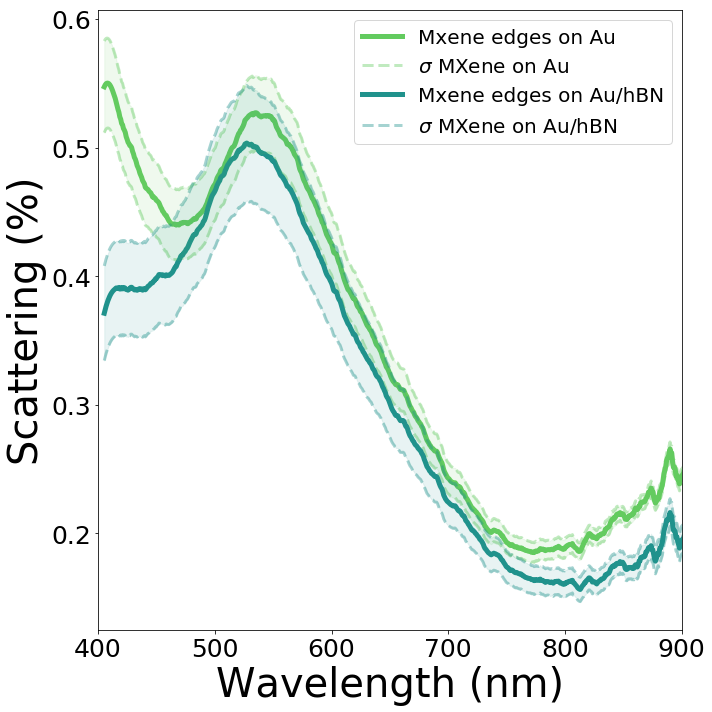

In [122]:

# Plot the average values of all spectra
colours_exp = cm.viridis(np.linspace(0,1,len(average_all_intensities_Au_2)))
colours_th = cm.hot(np.linspace(0,1,len(average_all_intensities_Au_2)))

fig1 = plt.figure(1, figsize = (10, 10))
ax1 = fig1.add_subplot(111)

ax1.plot(wavelength_store_Au_2[0], average_all_intensities_Au_2*100, label = 'Mxene edges on Au', linewidth = 5, color = colours_exp[600])
ax1.plot(wavelength_store_Au_2[0], av_stddev_Au_2*100 + average_all_intensities_Au_2*100, '--',color = colours_exp[600], label = "$\sigma$ MXene on Au",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Au_2[0], average_all_intensities_Au_2*100-av_stddev_Au_2*100, '--',color = colours_exp[600],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Au_2[0], average_all_intensities_Au_2*100 - av_stddev_Au_2*100,
                av_stddev_Au_2*100 + average_all_intensities_Au_2*100, color = colours_exp[600], 
                alpha = 0.1, zorder = 3)


ax1.plot(wavelength_store_Au_hBN[0], average_all_intensities_Au_hBN*100, label = 'Mxene edges on Au/hBN', linewidth = 5, color = colours_exp[400])
ax1.plot(wavelength_store_Au_hBN[0], av_stddev_Au_hBN*100 + average_all_intensities_Au_hBN*100, '--',color = colours_exp[400], label = "$\sigma$ MXene on Au/hBN",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Au_2[0], average_all_intensities_Au_hBN*100-av_stddev_Au_hBN*100, '--',color = colours_exp[400],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Au_hBN[0], average_all_intensities_Au_hBN*100 - av_stddev_Au_hBN*100,
                av_stddev_Au_hBN*100 + average_all_intensities_Au_hBN*100, color = colours_exp[400], 
                alpha = 0.1, zorder = 3)

#ax1.plot(wavelength_store_Au_hBN[0], average_all_intensities_Au_hBN_2, label = 'Mxene edges on Au/hBN_2', linewidth = 5, color = 'r')
ax1.set_xlim(400, 900)
ax1.set_xlabel('Wavelength (nm)', fontsize = 40)
ax1.set_ylabel('Scattering (%)', fontsize = 40)
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.legend( prop={'size': 20})
fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/Au_hBN_Mxene_raw.png', bbox_inches='tight')

In [96]:
data

array([ 0.0029031 ,  0.003071  ,  0.00414232,  0.00333042,  0.00332818,
        0.00404117,  0.0035509 ,  0.00277827,  0.00358374,  0.00354126,
        0.00358356,  0.00364403,  0.00321069,  0.00385518,  0.00312054,
        0.0038584 ,  0.00346222,  0.00370361,  0.00360113,  0.00371875,
        0.00388555,  0.00320816,  0.00326831,  0.00353705,  0.00375179,
        0.00367654,  0.00315276,  0.00365571,  0.00402829,  0.00328557,
        0.0034609 ,  0.00362009,  0.00361738,  0.0035242 ,  0.00405494,
        0.00367164,  0.00327484,  0.00346196,  0.0037078 ,  0.00341776,
        0.00311018,  0.00332474,  0.0033018 ,  0.00353313,  0.00370191,
        0.00346525,  0.00352679,  0.00333307,  0.00350663,  0.00341312,
        0.00320881,  0.00347004,  0.00358203,  0.00369393,  0.00332727,
        0.00335324,  0.00344295,  0.00343287,  0.00342731,  0.00341871,
        0.00373444,  0.00360319,  0.00347663,  0.00358704,  0.00346201,
        0.00350001,  0.0036196 ,  0.00348036,  0.00356873,  0.00

In [101]:
#Sort by timestamp

ref = filelist_DF[filelist_DF.keys()[0]].attrs['reference']
back = filelist_DF[filelist_DF.keys()[0]].attrs['background']
wavelengths = filelist_DF[filelist_DF.keys()[0]].attrs['wavelengths']
wavelength_start = 405; wavelength_end = 900;
data_start = (np.abs(wavelengths - wavelength_start)).argmin()
data_end = (np.abs(wavelengths - wavelength_end)).argmin()


wavelengths = wavelengths[data_start:data_end]

all_data_w_time = []

for data_set in filelist_DF.values():
    
    t = datetime.datetime.strptime(
                        data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")
    
    data = (data_set.value - back)/(ref-back)
    data = data[data_start:data_end]
    
    if t >= start_time_Au_hBN and t <= finish_time_Au_hBN: #Make sure you choose the right start and finish time

        s = (t-datetime.datetime(1970,1,1)).total_seconds()

        data_w_time = np.append(data, s)
        all_data_w_time.append(data_w_time)
    
    
all_data_w_time_sorted = sorted(all_data_w_time,key=lambda x: x[-1])
all_data_w_time_sorted = np.delete(all_data_w_time_sorted, -1,1)


#Filter the data to help define peaks
all_data_filtered = []
for i in range(0, len(all_data_w_time_sorted)):
    filt_data = sig.savgol_filter(all_data_w_time_sorted[i],23,3)
    all_data_filtered.append(filt_data)

C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in divide


In [102]:
#Decides how the normalisation is done
normalise_start = 405; #Wavelength to normalised from
normalise_start = (np.abs(wavelengths - normalise_start)).argmin()

del_selection = np.linspace(0,normalise_start, normalise_start+1, dtype = int)
norm_mat = np.delete(all_data_w_time_sorted, del_selection, 1)
norm_mat_filtered = np.delete(all_data_filtered, del_selection, 1)

inf_norm = np.linalg.norm(norm_mat, axis=1, ord = np.inf)
all_data_w_time_sorted_norm = all_data_w_time_sorted/inf_norm[:,None]
inf_norm_filtered = np.linalg.norm(norm_mat_filtered, axis= 1, ord = np.inf)
all_data_norm_filtered = all_data_filtered/inf_norm_filtered[:,None]


(0, 38.199999999999996)

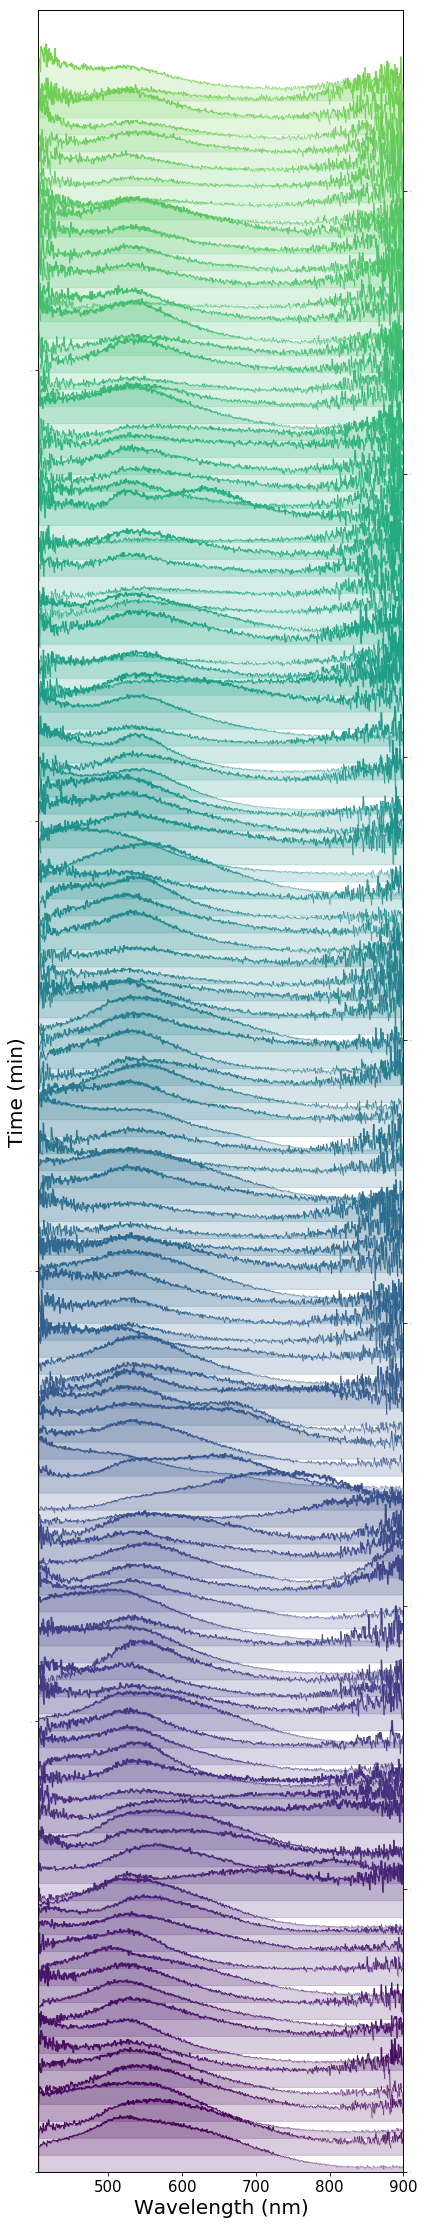

In [117]:
#Plot all the data with an offset

mega_fact = 0.3
all_data_w_time_sorted_offset_n = Alex_plot.offset_spectra(all_data_w_time_sorted_norm, mega_fact)

fig1 = plt.figure(1, figsize = (6,0.25*len(all_data_w_time_sorted_offset_n)))
ax1 = fig1.add_subplot(111)
ax1b = ax1.twinx()


#colours = parula_map(np.linspace(0,0.8,len(all_data_w_time_sorted_offset_n)))
colours = cm.viridis(np.linspace(0,0.8,len(all_data_w_time_sorted_offset_n)))
for i in range(0, len(all_data_w_time_sorted_offset_n)-1):
    lwidths = (all_data_w_time_sorted_offset_n[i] - i*mega_fact)*2
    points = np.array([wavelengths, all_data_w_time_sorted_offset_n[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax1b.add_collection(lc_2)
    spec1 = np.array(all_data_w_time_sorted_offset_n[i], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
    spec2 = np.ones(len(wavelengths))*i*mega_fact
    ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
                alpha = 0.2, zorder = 3)

    
#ax1.axhline(1, 405, 1000, color = 'r', linewidth = 10)
ax1.set_xlim(405, 900)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Time (min)", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=0)
ax1b.tick_params(axis='y', labelsize=0)
ax1.set_ylim(0,24)
ax1b.set_ylim(0, len(all_data_w_time_sorted_offset_n)*mega_fact + 1)

In [19]:
#Plot a selection of spectra 
#0,5,6,13,16,18,24, 25, are clear flake edges
ind_pos_Si = [0, 5, 6, 13, 16, 24, 25]
clear_edges_Si = []
for i in range(0, len(ind_pos_Si)):
    clear_edges_Si.append(all_data_filtered[ind_pos_Si[i]])

#31, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 57, 58, 59, no 63 or 64 no 66, 67, 68,

ind_pos_Au = np.linspace(27,56, dtype = int)
clear_edges_Au = []
for i in range(0, len(ind_pos_Au)):
    clear_edges_Au.append(all_data_filtered[ind_pos_Au[i]])
    

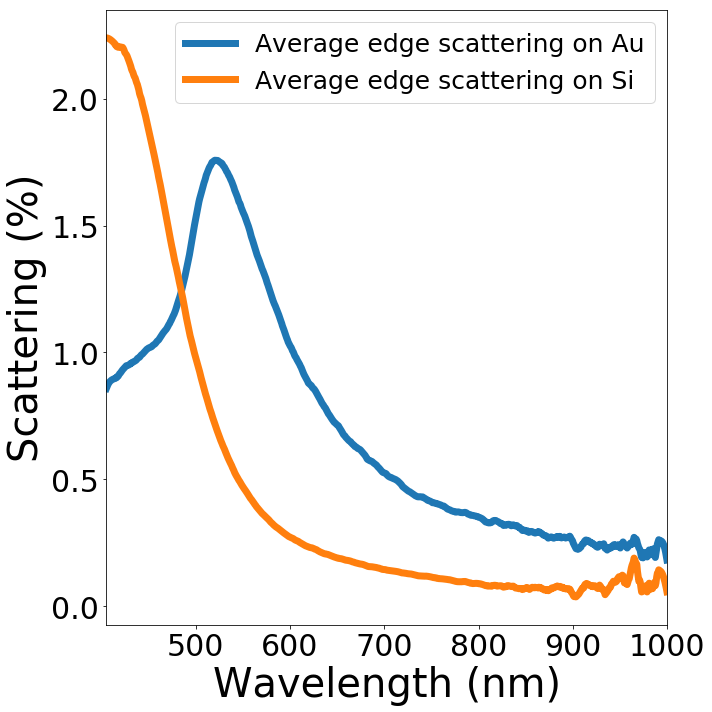

In [25]:
clear_edges_Au_av = np.mean(clear_edges_Au, axis = 0)
clear_edges_Si_av = np.mean(clear_edges_Si, axis = 0)
clear_edges_Au_av = 

fig1 = plt.figure(1, figsize = (10,10))
ax1 = fig1.add_subplot(111)
ax1.plot(wavelengths, clear_edges_Au_av*100, label = 'Average edge scattering on Au', linewidth = 7)
ax1.plot(wavelength_store_Au[0], av_stddev_Au*100 + average_all_intensities_Au*100, '--',color = colours_exp[600], label = "$\sigma$ Mxene edge on Au",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Au[0], average_all_intensities_Au*100-av_stddev_Au*100, '--',color = colours_exp[600],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Au[0], average_all_intensities_Au*100 - av_stddev_Au*100,
                av_stddev_Au*100 + average_all_intensities_Au*100, color = colours_exp[600], 
                alpha = 0.1, zorder = 3)

ax1.plot(wavelengths, clear_edges_Si_av*100, label = 'Average edge scattering on Si', linewidth = 7, color = colours_exp[200]) 
ax1.plot(wavelength_store_Au[0], av_stddev_Au*100 + average_all_intensities_Au*100, '--',color = colours_exp[600], label = "$\sigma$ Mxene edge on Au",  linewidth = 3, alpha = 0.4)
ax1.plot(wavelength_store_Au[0], average_all_intensities_Au*100-av_stddev_Au*100, '--',color = colours_exp[600],  linewidth = 3, alpha = 0.4)
ax1.fill_between(wavelength_store_Au[0], average_all_intensities_Au*100 - av_stddev_Au*100,
                av_stddev_Au*100 + average_all_intensities_Au*100, color = colours_exp[600], 
                alpha = 0.1, zorder = 3)

ax1.set_ylabel('Scattering (%)', fontsize = 40)
ax1.set_xlabel('Wavelength (nm)', fontsize = 40)
ax1.set_xlim(405, 1000)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend( prop={'size': 25})

fig1.savefig('C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/MXene NPls/On_off_Au_comparison_selected.png', bbox_inches='tight')


(0, 0.6)

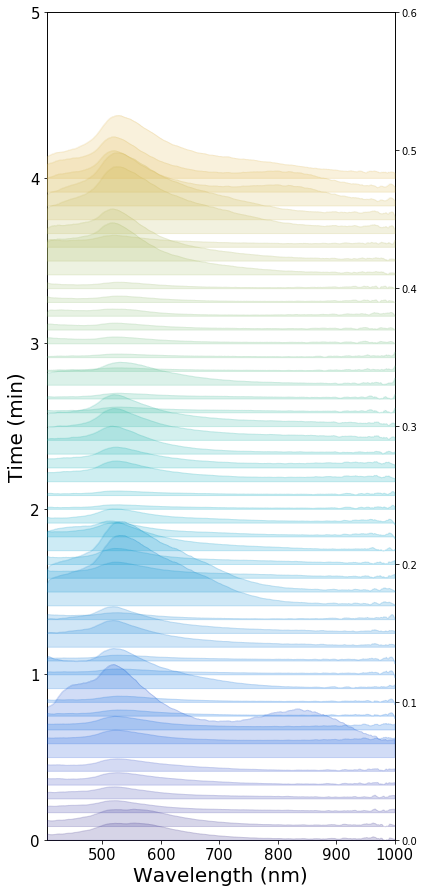

In [36]:
mega_fact = 0.01
clear_edges_Au_os = Alex_plot.offset_spectra(clear_edges_Au, mega_fact)

fig1 = plt.figure(1, figsize = (6,0.25*len(clear_edges_Au_os)))
ax1 = fig1.add_subplot(111)
ax1b = ax1.twinx()


colours = parula_map(np.linspace(0,0.8,len(clear_edges_Au_os)))
for i in range(0, len(clear_edges_Au_os)-1):
    lwidths = (clear_edges_Au_os[i] - i*mega_fact)*2
    points = np.array([wavelengths, clear_edges_Au_os[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax1b.add_collection(lc_2)
    spec1 = np.array(clear_edges_Au_os[i], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
    spec2 = np.ones(len(wavelengths))*i*mega_fact
    ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
                alpha = 0.2, zorder = 3)

    
#ax1.axhline(1, 405, 1000, color = 'r', linewidth = 10)
ax1.set_xlim(405, 1000)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Spectrum number", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0,5)
ax1b.set_ylim(0, 0.6)

In [38]:
#Decides how the normalisation is done
normalise_start = 405; #Wavelength to normalised from
normalise_start = (np.abs(wavelengths - normalise_start)).argmin()

del_selection = np.linspace(0,normalise_start, normalise_start+1, dtype = int)
norm_mat = np.delete(clear_edges_Au, del_selection, 1)

inf_norm = np.linalg.norm(norm_mat, axis=1, ord = np.inf)
clear_edges_Au_norm = clear_edges_Au/inf_norm[:,None]

(0, 16)

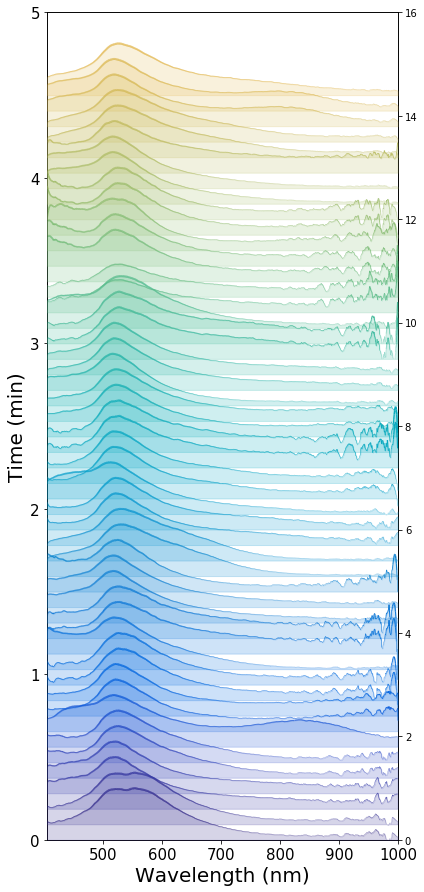

In [48]:
mega_fact = 0.3
clear_edges_Au_norm_os = Alex_plot.offset_spectra(clear_edges_Au_norm , mega_fact)

fig1 = plt.figure(1, figsize = (6,0.25*len(clear_edges_Au_norm_os)))
ax1 = fig1.add_subplot(111)
ax1b = ax1.twinx()


colours = parula_map(np.linspace(0,0.8,len(clear_edges_Au_norm_os)))
for i in range(0, len(clear_edges_Au_norm_os)-1):
    lwidths = (clear_edges_Au_norm_os[i] - i*mega_fact)*2
    points = np.array([wavelengths, clear_edges_Au_norm_os[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax1b.add_collection(lc_2)
    spec1 = np.array(clear_edges_Au_norm_os[i], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
    spec2 = np.ones(len(wavelengths))*i*mega_fact
    ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
                alpha = 0.2, zorder = 3)

    
#ax1.axhline(1, 405, 1000, color = 'r', linewidth = 10)
ax1.set_xlim(405, 1000)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Time (min)", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0,5)
ax1b.set_ylim(0, 16)



(0, 16)

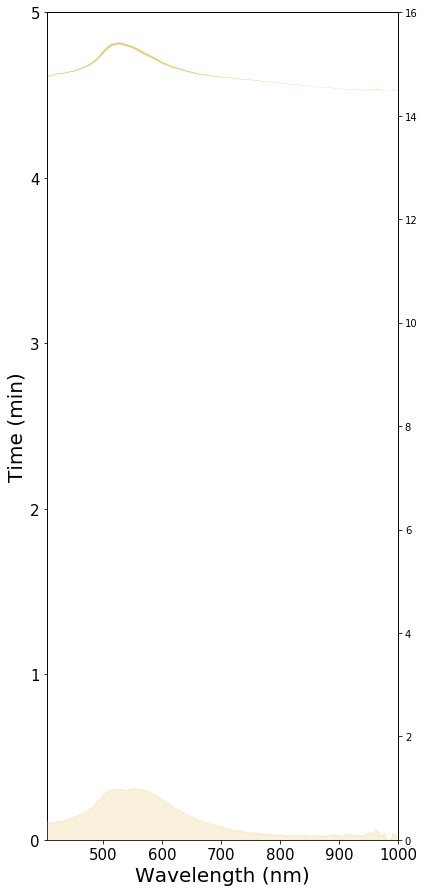

In [50]:
mega_fact = 0.3
clear_edges_Au_norm_os = Alex_plot.offset_spectra(clear_edges_Au_norm , mega_fact)

fig1 = plt.figure(1, figsize = (6,0.25*len(clear_edges_Au_norm_os)))
ax1 = fig1.add_subplot(111)
ax1b = ax1.twinx()


colours = parula_map(np.linspace(0,0.8,len(clear_edges_Au_norm_os)))

lwidths = (clear_edges_Au_norm_os[0] - 0*mega_fact)*2
points = np.array([wavelengths, clear_edges_Au_norm_os[i]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)
lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
ax1b.add_collection(lc_2)
spec1 = np.array(clear_edges_Au_norm_os[0], dtype = float)
#     spec2 = np.array(len(all_data_w_time_sorted_offset_n[i])*[i], dtype = float)
spec2 = np.ones(len(wavelengths))*0*mega_fact
ax1b.fill_between(wavelengths, spec1, spec2, color = colours[i], 
            alpha = 0.2, zorder = 3)

    
#ax1.axhline(1, 405, 1000, color = 'r', linewidth = 10)
ax1.set_xlim(405, 1000)
ax1.set_xlabel("Wavelength (nm)", fontsize = 20)
ax1.set_ylabel("Time (min)", fontsize = 20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_ylim(0,5)
ax1b.set_ylim(0, 16)